# Chapter 8: Advanced Topics - Loop Closure and Global Optimization

## Learning Objectives
- Understand loop closure detection and validation
- Implement incremental pose graph optimization
- Learn about graph sparsification techniques
- Explore multi-robot and hierarchical optimization
- Build a complete SLAM system with Symforce

## 1. Loop Closure Detection and Validation

Loop closures are crucial for global consistency in SLAM. They connect distant parts of the trajectory, reducing drift accumulation.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import symforce
symforce.set_epsilon_to_number(1e-8)
import symforce.symbolic as sf
from symforce import ops
from symforce.values import Values
from symforce.opt.optimizer import Optimizer
from symforce.opt.factor import Factor
from typing import List, Tuple, Dict, Optional, Set
import time
from collections import deque
import networkx as nx

In [74]:
class LoopClosureDetector:
    def __init__(self, distance_threshold: float = 2.0, 
                 time_threshold: int = 50,
                 max_candidates: int = 10):
        self.distance_threshold = distance_threshold
        self.time_threshold = time_threshold
        self.max_candidates = max_candidates
        self.pose_history = []
        self.kdtree = None
    
    def add_pose(self, pose_id: int, x: float, y: float, theta: float):
        """Add a new pose to the detector"""
        self.pose_history.append((pose_id, x, y, theta))
        
        # Rebuild KD-tree periodically for efficiency
        if len(self.pose_history) % 10 == 0:
            positions = np.array([[p[1], p[2]] for p in self.pose_history])
            self.kdtree = KDTree(positions)
    
    def find_loop_closure_candidates(self, current_id: int) -> List[int]:
        """Find potential loop closure candidates for current pose"""
        if len(self.pose_history) < self.time_threshold or self.kdtree is None:
            return []
        
        current_pose = self.pose_history[current_id]
        current_pos = np.array([current_pose[1], current_pose[2]])
        
        # Find nearby poses
        indices = self.kdtree.query_ball_point(current_pos, self.distance_threshold)
        
        # Filter candidates
        candidates = []
        for idx in indices:
            candidate_id = self.pose_history[idx][0]
            
            # Skip recent poses
            if abs(current_id - candidate_id) < self.time_threshold:
                continue
            
            # Compute actual distance
            candidate_pos = np.array([self.pose_history[idx][1], 
                                    self.pose_history[idx][2]])
            distance = np.linalg.norm(current_pos - candidate_pos)
            
            candidates.append((candidate_id, distance))
        
        # Sort by distance and return top candidates
        candidates.sort(key=lambda x: x[1])
        return [c[0] for c in candidates[:self.max_candidates]]
    
    def validate_loop_closure(self, pose_i: np.ndarray, pose_j: np.ndarray,
                            measurement: np.ndarray, 
                            chi2_threshold: float = 5.991) -> bool:
        """Validate loop closure using chi-squared test"""
        # Compute predicted measurement
        c = np.cos(pose_i[2])
        s = np.sin(pose_i[2])
        dx_pred = c * (pose_j[0] - pose_i[0]) + s * (pose_j[1] - pose_i[1])
        dy_pred = -s * (pose_j[0] - pose_i[0]) + c * (pose_j[1] - pose_i[1])
        dtheta_pred = pose_j[2] - pose_i[2]
        
        # Normalize angle
        dtheta_pred = np.arctan2(np.sin(dtheta_pred), np.cos(dtheta_pred))
        
        # Compute error
        error = np.array([
            dx_pred - measurement[0],
            dy_pred - measurement[1],
            np.arctan2(np.sin(dtheta_pred - measurement[2]), 
                      np.cos(dtheta_pred - measurement[2]))
        ])
        
        # Assume diagonal covariance for simplicity
        cov = np.diag([0.1, 0.1, 0.05])**2
        
        # Chi-squared test
        chi2 = error.T @ np.linalg.inv(cov) @ error
        
        return chi2 < chi2_threshold

## 2. Incremental Pose Graph Optimization

For real-time SLAM, we need incremental optimization that efficiently updates the solution as new constraints arrive.

In [75]:
class IncrementalPoseGraphOptimizer:
    def __init__(self, window_size: int = 50):
        self.vertices = {}  # id -> (x, y, theta)
        self.edges = []     # (i, j, measurement, info_matrix)
        self.fixed_vertices = set([0])
        self.window_size = window_size
        self.active_vertices = deque(maxlen=window_size)
        self.marginalized_vertices = set()
        
        # For Symforce optimization
        self.values = Values()
        self.factors = []
        self.optimizer = None
    
    def add_vertex(self, vertex_id: int, x: float, y: float, theta: float):
        """Add a new vertex to the graph"""
        self.vertices[vertex_id] = np.array([x, y, theta])
        self.active_vertices.append(vertex_id)
        
        # Add to Symforce values
        self.values[f'pose_{vertex_id}'] = sf.Pose2(
            t=sf.V2(x, y),
            R=sf.Rot2.from_angle(theta)
        )
        
        # Check if we need to marginalize old vertices
        if len(self.active_vertices) == self.window_size:
            self._marginalize_oldest_vertex()
    
    def add_edge(self, i: int, j: int, dx: float, dy: float, dtheta: float,
                 info_matrix: np.ndarray = None, is_loop_closure: bool = False):
        """Add an edge to the graph"""
        if info_matrix is None:
            info_matrix = np.eye(3)
        
        measurement = sf.Pose2(
            t=sf.V2(dx, dy),
            R=sf.Rot2.from_angle(dtheta)
        )
        
        self.edges.append((i, j, measurement, info_matrix, is_loop_closure))
        
        # Only add factor if both vertices are active
        if i not in self.marginalized_vertices and j not in self.marginalized_vertices:
            self._add_edge_factor(i, j, measurement, info_matrix)
    
    def _add_edge_factor(self, i: int, j: int, measurement: sf.Pose2, 
                        info_matrix: np.ndarray):
        """Add edge factor to Symforce optimizer"""
        # Store information matrix square root for this edge
        sqrt_info = np.linalg.cholesky(info_matrix)
        
        def edge_residual(pose_i: sf.Pose2, pose_j: sf.Pose2) -> sf.V3:
            T_ij_predicted = pose_i.inverse() * pose_j
            T_error = measurement.inverse() * T_ij_predicted
            
            # Get error vector
            error_x = T_error.position()[0]
            error_y = T_error.position()[1]
            error_theta = T_error.rotation().to_tangent()[0]
            
            # Apply information matrix weighting element by element
            weighted_x = sqrt_info[0, 0] * error_x + sqrt_info[0, 1] * error_y + sqrt_info[0, 2] * error_theta
            weighted_y = sqrt_info[1, 0] * error_x + sqrt_info[1, 1] * error_y + sqrt_info[1, 2] * error_theta
            weighted_theta = sqrt_info[2, 0] * error_x + sqrt_info[2, 1] * error_y + sqrt_info[2, 2] * error_theta
            
            return sf.V3(weighted_x, weighted_y, weighted_theta)
        
        # Create factor
        factor = Factor(
            residual=edge_residual,
            keys=[f'pose_{i}', f'pose_{j}']
        )
        
        self.factors.append(factor)
    
    def _marginalize_oldest_vertex(self):
        """Marginalize the oldest vertex using Schur complement"""
        if len(self.active_vertices) < self.window_size:
            return
        
        oldest = self.active_vertices[0]
        if oldest in self.fixed_vertices:
            return
        
        # Mark as marginalized
        self.marginalized_vertices.add(oldest)
        
        # TODO: Implement proper marginalization
        # For now, we'll just fix the vertex
        self.fixed_vertices.add(oldest)
    
    def optimize_incremental(self, max_iterations: int = 10) -> Dict[str, List[float]]:
        """Perform incremental optimization on active window"""
        if not self.factors:
            return {'error': [], 'time': []}
        
        # Get active vertices that are not fixed
        optimized_keys = [f'pose_{v}' for v in self.active_vertices 
                         if v not in self.fixed_vertices]
        
        # Filter factors to only include those with both vertices in the active set
        active_vertices_set = set(self.active_vertices)
        active_factors = []
        
        for factor in self.factors:
            # Extract vertex IDs from factor keys
            vertex_ids = []
            for key in factor.keys:
                if key.startswith('pose_'):
                    vertex_id = int(key.split('_')[1])
                    vertex_ids.append(vertex_id)
            
            # Only include factor if all vertices are active
            if all(v in active_vertices_set for v in vertex_ids):
                active_factors.append(factor)
        
        if optimized_keys and active_factors:  # Only optimize if there are keys and factors
            # Create optimizer params without debug_stats
            from symforce.opt.optimizer import Optimizer as SymforceOptimizer
            
            self.optimizer = SymforceOptimizer(
                factors=active_factors,
                optimized_keys=optimized_keys
            )
            
            # Optimize
            start_time = time.time()
            result = self.optimizer.optimize(self.values, num_iterations=max_iterations)
            opt_time = time.time() - start_time
            
            # Update vertex positions
            for v in self.active_vertices:
                if v not in self.fixed_vertices and f'pose_{v}' in result.optimized_values:
                    pose = result.optimized_values[f'pose_{v}']
                    # Extract position
                    x = float(pose.position()[0])
                    y = float(pose.position()[1])
                    # Extract angle from rotation - convert symbolic to float
                    rot_storage = pose.rotation().to_storage()
                    angle = np.arctan2(float(rot_storage[1]), float(rot_storage[0]))
                    
                    self.vertices[v] = np.array([x, y, angle])
            
            # Update values for next iteration
            self.values = result.optimized_values
            
            return {
                'error': [result.error()],
                'time': [opt_time],
                'iterations': result.iterations
            }
        else:
            return {'error': [], 'time': []}

## 3. Graph Sparsification

As the graph grows, we need to sparsify it to maintain computational efficiency while preserving accuracy.

In [76]:
class GraphSparsifier:
    def __init__(self, optimizer):
        self.optimizer = optimizer
    
    def compute_edge_importance(self) -> Dict[Tuple[int, int], float]:
        """Compute importance score for each edge using information gain"""
        edge_scores = {}
        
        for i, j, measurement, info_matrix, is_loop_closure in self.optimizer.edges:
            # Skip edges with marginalized vertices
            if i in self.optimizer.marginalized_vertices or j in self.optimizer.marginalized_vertices:
                continue
                
            # Loop closures are always important
            if is_loop_closure:
                edge_scores[(i, j)] = float('inf')
                continue
            
            # Compute error for this edge
            pose_i = self.optimizer.vertices[i]
            pose_j = self.optimizer.vertices[j]
            
            # Predicted measurement
            c = np.cos(pose_i[2])
            s = np.sin(pose_i[2])
            dx_pred = c * (pose_j[0] - pose_i[0]) + s * (pose_j[1] - pose_i[1])
            dy_pred = -s * (pose_j[0] - pose_i[0]) + c * (pose_j[1] - pose_i[1])
            dtheta_pred = np.arctan2(np.sin(pose_j[2] - pose_i[2]), 
                                    np.cos(pose_j[2] - pose_i[2]))
            
            # Error (measurement is a sf.Pose2 object)
            # Extract measurement values
            meas_x = float(measurement.t[0])
            meas_y = float(measurement.t[1])
            # Get angle from rotation - convert symbolic values to float first
            rot_storage = measurement.R.to_storage()
            meas_theta = np.arctan2(float(rot_storage[1]), float(rot_storage[0]))
            
            error = np.array([
                dx_pred - meas_x,
                dy_pred - meas_y,
                dtheta_pred - meas_theta
            ])
            
            # Information gain (simplified)
            score = error.T @ info_matrix @ error
            edge_scores[(i, j)] = score
        
        return edge_scores
    
    def sparsify_chow_liu(self, target_edges: int) -> List[Tuple[int, int]]:
        """Sparsify using Chow-Liu tree approximation"""
        # Build graph
        G = nx.Graph()
        edge_scores = self.compute_edge_importance()
        
        for (i, j), score in edge_scores.items():
            G.add_edge(i, j, weight=-score)  # Negative for maximum spanning tree
        
        # Find maximum spanning tree
        mst = nx.maximum_spanning_tree(G)
        
        # Add edges back based on importance
        selected_edges = set(mst.edges())
        remaining_edges = [(e, s) for e, s in edge_scores.items() 
                          if e not in selected_edges and s != float('inf')]
        remaining_edges.sort(key=lambda x: x[1], reverse=True)
        
        # Add important edges until target reached
        for edge, _ in remaining_edges:
            if len(selected_edges) >= target_edges:
                break
            selected_edges.add(edge)
        
        # Always keep loop closures
        for edge, score in edge_scores.items():
            if score == float('inf'):
                selected_edges.add(edge)
        
        return list(selected_edges)
    
    def apply_sparsification(self, selected_edges: List[Tuple[int, int]]):
        """Apply sparsification to the optimizer"""
        # Create edge lookup
        edge_set = set(selected_edges)
        
        # Filter edges
        new_edges = []
        new_factors = []
        
        for idx, (i, j, measurement, info_matrix, is_loop_closure) in enumerate(self.optimizer.edges):
            if (i, j) in edge_set or (j, i) in edge_set:
                new_edges.append((i, j, measurement, info_matrix, is_loop_closure))
                # Only keep factors that don't reference marginalized vertices
                if i not in self.optimizer.marginalized_vertices and j not in self.optimizer.marginalized_vertices:
                    if idx < len(self.optimizer.factors):
                        new_factors.append(self.optimizer.factors[idx])
        
        self.optimizer.edges = new_edges
        self.optimizer.factors = new_factors

## 4. Complete SLAM System Example

Let's build a complete SLAM system that combines all the techniques we've learned.

In [77]:
class CompleteSLAMSystem:
    def __init__(self, loop_closure_config: Dict = None, 
                 sparsification_config: Dict = None):
        # Core components
        self.optimizer = IncrementalPoseGraphOptimizer(window_size=100)
        self.loop_detector = LoopClosureDetector(
            **(loop_closure_config or {})
        )
        self.sparsifier = GraphSparsifier(self.optimizer)
        
        # Configuration
        self.sparsification_interval = sparsification_config.get('interval', 100) if sparsification_config else 100
        self.target_edge_ratio = sparsification_config.get('target_ratio', 0.5) if sparsification_config else 0.5
        
        # Statistics
        self.stats = {
            'poses': [],
            'edges': [],
            'loop_closures': [],
            'optimization_time': [],
            'total_error': []
        }
    
    def add_odometry_measurement(self, pose_id: int, x: float, y: float, theta: float,
                               dx: float, dy: float, dtheta: float,
                               covariance: np.ndarray = None):
        """Process new odometry measurement"""
        # Add vertex
        self.optimizer.add_vertex(pose_id, x, y, theta)
        self.loop_detector.add_pose(pose_id, x, y, theta)
        
        # Add odometry edge
        if pose_id > 0:
            if covariance is None:
                covariance = np.diag([0.1, 0.1, 0.05])**2
            info_matrix = np.linalg.inv(covariance)
            
            self.optimizer.add_edge(pose_id - 1, pose_id, dx, dy, dtheta, 
                                  info_matrix, is_loop_closure=False)
        
        # Check for loop closures
        loop_candidates = self.loop_detector.find_loop_closure_candidates(pose_id)
        
        for candidate_id in loop_candidates:
            # Simulate loop closure detection (in practice, this would use sensors)
            success, measurement = self._detect_loop_closure(pose_id, candidate_id)
            
            if success:
                # Validate loop closure
                pose_current = self.optimizer.vertices[pose_id]
                pose_candidate = self.optimizer.vertices[candidate_id]
                
                if self.loop_detector.validate_loop_closure(
                    pose_candidate, pose_current, measurement
                ):
                    # Add loop closure edge
                    lc_cov = np.diag([0.2, 0.2, 0.1])**2
                    lc_info = np.linalg.inv(lc_cov)
                    
                    self.optimizer.add_edge(
                        candidate_id, pose_id, 
                        measurement[0], measurement[1], measurement[2],
                        lc_info, is_loop_closure=True
                    )
                    
                    self.stats['loop_closures'].append((candidate_id, pose_id))
                    print(f"Loop closure detected: {candidate_id} -> {pose_id}")
        
        # Optimize
        opt_result = self.optimizer.optimize_incremental(max_iterations=10)
        
        # Update statistics
        self.stats['poses'].append(pose_id)
        self.stats['edges'].append(len(self.optimizer.edges))
        self.stats['optimization_time'].extend(opt_result['time'])
        self.stats['total_error'].extend(opt_result['error'])
        
        # Sparsify periodically
        if pose_id > 0 and pose_id % self.sparsification_interval == 0:
            self._sparsify_graph()
    
    def _detect_loop_closure(self, current_id: int, candidate_id: int) -> Tuple[bool, np.ndarray]:
        """Simulate loop closure detection"""
        # In a real system, this would use place recognition and scan matching
        # Here we simulate it based on ground truth with noise
        
        pose_current = self.optimizer.vertices[current_id]
        pose_candidate = self.optimizer.vertices[candidate_id]
        
        # Only detect if actually close
        distance = np.linalg.norm(pose_current[:2] - pose_candidate[:2])
        if distance > 2.0:
            return False, None
        
        # Compute relative pose with noise
        c = np.cos(pose_candidate[2])
        s = np.sin(pose_candidate[2])
        dx_true = c * (pose_current[0] - pose_candidate[0]) + s * (pose_current[1] - pose_candidate[1])
        dy_true = -s * (pose_current[0] - pose_candidate[0]) + c * (pose_current[1] - pose_candidate[1])
        dtheta_true = pose_current[2] - pose_candidate[2]
        
        # Add noise
        dx = dx_true + np.random.normal(0, 0.1)
        dy = dy_true + np.random.normal(0, 0.1)
        dtheta = dtheta_true + np.random.normal(0, 0.05)
        
        return True, np.array([dx, dy, dtheta])
    
    def _sparsify_graph(self):
        """Sparsify the pose graph"""
        print(f"\nSparsifying graph...")
        n_edges_before = len(self.optimizer.edges)
        
        target_edges = int(n_edges_before * self.target_edge_ratio)
        selected_edges = self.sparsifier.sparsify_chow_liu(target_edges)
        self.sparsifier.apply_sparsification(selected_edges)
        
        n_edges_after = len(self.optimizer.edges)
        print(f"Sparsified: {n_edges_before} -> {n_edges_after} edges")
    
    def get_trajectory(self) -> np.ndarray:
        """Get the optimized trajectory"""
        poses = []
        for i in sorted(self.optimizer.vertices.keys()):
            poses.append(self.optimizer.vertices[i])
        return np.array(poses)

## 5. Testing the Complete System

In [78]:
def simulate_slam_scenario(n_poses: int = 200, noise_level: float = 0.1):
    """Simulate a SLAM scenario with noisy odometry"""
    # Create SLAM system
    slam = CompleteSLAMSystem(
        loop_closure_config={
            'distance_threshold': 2.0,
            'time_threshold': 30,
            'max_candidates': 5
        },
        sparsification_config={
            'interval': 50,
            'target_ratio': 0.7
        }
    )
    
    # Generate figure-8 trajectory
    t = np.linspace(0, 4*np.pi, n_poses)
    scale = 10.0
    
    ground_truth = []
    
    for i in range(n_poses):
        # Figure-8 parametric equations
        x_true = scale * np.sin(t[i])
        y_true = scale * np.sin(t[i]) * np.cos(t[i])
        
        # Compute heading (tangent direction)
        if i < n_poses - 1:
            dx = scale * np.cos(t[i+1])
            dy = scale * (np.cos(t[i+1]) * np.cos(t[i+1]) - np.sin(t[i+1]) * np.sin(t[i+1]))
            theta_true = np.arctan2(dy, dx)
        else:
            theta_true = ground_truth[-1][2]
        
        ground_truth.append([x_true, y_true, theta_true])
        
        # Generate noisy odometry
        if i == 0:
            # First pose
            slam.add_odometry_measurement(i, x_true, y_true, theta_true, 0, 0, 0)
        else:
            # Compute true odometry
            prev = ground_truth[i-1]
            c = np.cos(prev[2])
            s = np.sin(prev[2])
            
            dx_global = x_true - prev[0]
            dy_global = y_true - prev[1]
            
            dx_true = c * dx_global + s * dy_global
            dy_true = -s * dx_global + c * dy_global
            dtheta_true = theta_true - prev[2]
            
            # Add noise
            dx = dx_true + np.random.normal(0, noise_level)
            dy = dy_true + np.random.normal(0, noise_level)
            dtheta = dtheta_true + np.random.normal(0, noise_level * 0.5)
            
            # Dead reckoning for initial guess
            x_dr = slam.optimizer.vertices[i-1][0] + c * dx - s * dy
            y_dr = slam.optimizer.vertices[i-1][1] + s * dx + c * dy
            theta_dr = slam.optimizer.vertices[i-1][2] + dtheta
            
            slam.add_odometry_measurement(i, x_dr, y_dr, theta_dr, dx, dy, dtheta)
        
        # Progress
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{n_poses} poses")
    
    return slam, np.array(ground_truth)

# Run simulation
np.random.seed(42)
print("Running SLAM simulation...")
slam_system, ground_truth = simulate_slam_scenario(n_poses=200, noise_level=0.05)

Running SLAM simulation...
[2025-07-08 03:27:52.919] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 5.630e-30/5.574e-30/5.630e-30, rel reduction: 0.00000e+00, gain ratio: 0.00000e+00
[2025-07-08 03:27:52.919] [info] LM<sym::Optimize> Optimization finished with status: SUCCESS
[2025-07-08 03:27:52.921] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.205e-02/1.193e-02/9.784e-03, rel reduction: 1.88237e-01, gain ratio: 1.88277e+01
[2025-07-08 03:27:52.921] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 9.784e-03/9.686e-03/7.930e-03, rel reduction: 1.89551e-01, gain ratio: 1.89554e+01
[2025-07-08 03:27:52.921] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 7.930e-03/7.850e-03/6.424e-03, rel reduction: 1.89887e-01, gain ratio: 1.89887e+01
[2025-07-08 03:27:52.921] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 6.424e-03/6.360e-03/5.

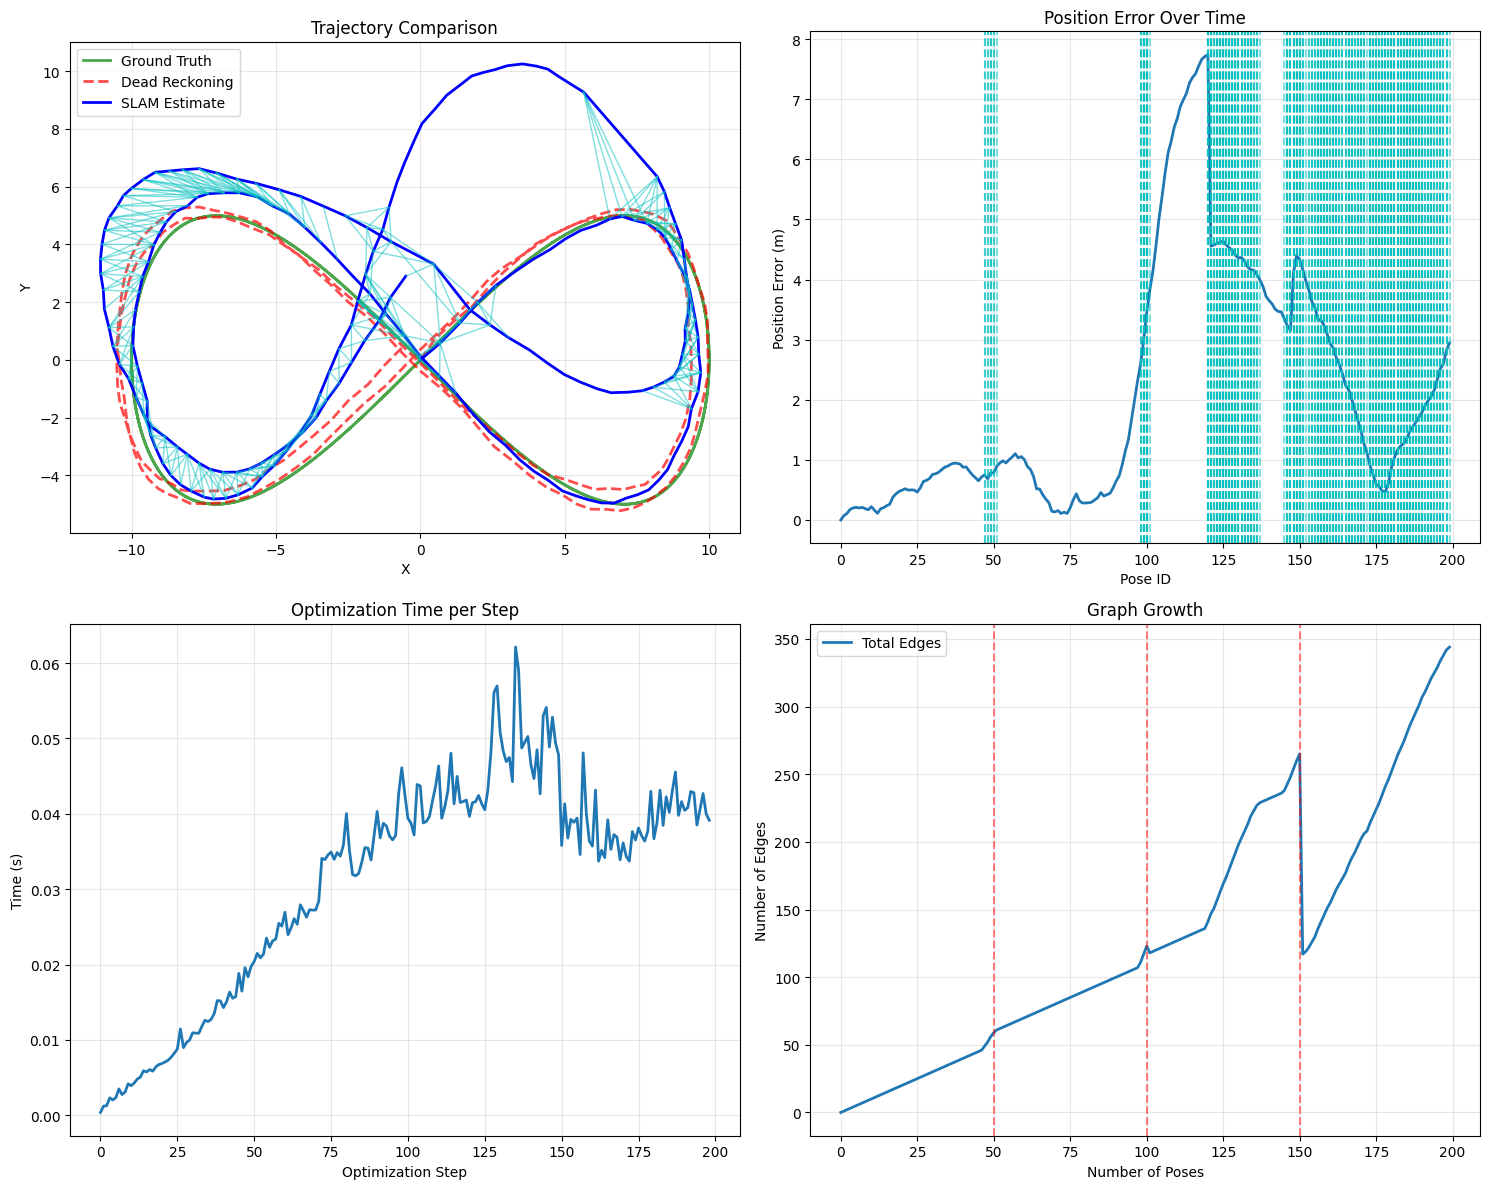


SLAM System Summary:
Total poses: 200
Total edges: 344
Loop closures detected: 304
Mean position error: 2.090 m
Final position error: 2.944 m
Mean optimization time: 0.031 s


In [79]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Trajectory comparison
ax = axes[0, 0]
trajectory = slam_system.get_trajectory()

# Dead reckoning (no loop closures)
dead_reckoning = [ground_truth[0]]
for i in range(1, len(ground_truth)):
    prev = dead_reckoning[-1]
    # Use noisy odometry to accumulate
    c = np.cos(prev[2])
    s = np.sin(prev[2])
    
    dx_global = ground_truth[i][0] - ground_truth[i-1][0]
    dy_global = ground_truth[i][1] - ground_truth[i-1][1]
    dx_local = c * dx_global + s * dy_global + np.random.normal(0, 0.05)
    dy_local = -s * dx_global + c * dy_global + np.random.normal(0, 0.05)
    dtheta = ground_truth[i][2] - ground_truth[i-1][2] + np.random.normal(0, 0.025)
    
    x_next = prev[0] + c * dx_local - s * dy_local
    y_next = prev[1] + s * dx_local + c * dy_local
    theta_next = prev[2] + dtheta
    
    dead_reckoning.append([x_next, y_next, theta_next])

dead_reckoning = np.array(dead_reckoning)

ax.plot(ground_truth[:, 0], ground_truth[:, 1], 'g-', linewidth=2, 
        label='Ground Truth', alpha=0.7)
ax.plot(dead_reckoning[:, 0], dead_reckoning[:, 1], 'r--', linewidth=2,
        label='Dead Reckoning', alpha=0.7)
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2,
        label='SLAM Estimate')

# Plot loop closures
for lc in slam_system.stats['loop_closures']:
    i, j = lc
    ax.plot([trajectory[i, 0], trajectory[j, 0]], 
            [trajectory[i, 1], trajectory[j, 1]], 
            'c-', alpha=0.5, linewidth=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Error over time
ax = axes[0, 1]
position_errors = np.linalg.norm(trajectory[:, :2] - ground_truth[:, :2], axis=1)
ax.plot(position_errors, linewidth=2)
ax.set_xlabel('Pose ID')
ax.set_ylabel('Position Error (m)')
ax.set_title('Position Error Over Time')
ax.grid(True, alpha=0.3)

# Add loop closure markers
for lc in slam_system.stats['loop_closures']:
    ax.axvline(x=lc[1], color='c', alpha=0.5, linestyle='--')

# Optimization statistics
ax = axes[1, 0]
ax.plot(slam_system.stats['optimization_time'], linewidth=2)
ax.set_xlabel('Optimization Step')
ax.set_ylabel('Time (s)')
ax.set_title('Optimization Time per Step')
ax.grid(True, alpha=0.3)

# Graph statistics
ax = axes[1, 1]
ax.plot(slam_system.stats['poses'], slam_system.stats['edges'], 
        linewidth=2, label='Total Edges')
ax.set_xlabel('Number of Poses')
ax.set_ylabel('Number of Edges')
ax.set_title('Graph Growth')
ax.grid(True, alpha=0.3)

# Mark sparsification events
sparsification_poses = [i for i in slam_system.stats['poses'] 
                       if i > 0 and i % slam_system.sparsification_interval == 0]
for sp in sparsification_poses:
    ax.axvline(x=sp, color='r', alpha=0.5, linestyle='--')

ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSLAM System Summary:")
print(f"Total poses: {len(trajectory)}")
print(f"Total edges: {len(slam_system.optimizer.edges)}")
print(f"Loop closures detected: {len(slam_system.stats['loop_closures'])}")
print(f"Mean position error: {np.mean(position_errors):.3f} m")
print(f"Final position error: {position_errors[-1]:.3f} m")
print(f"Mean optimization time: {np.mean(slam_system.stats['optimization_time']):.3f} s")

## 6. Multi-Robot SLAM Extension

Let's extend our system to handle multiple robots.

In [80]:
class MultiRobotSLAM:
    def __init__(self, n_robots: int):
        self.n_robots = n_robots
        self.robot_systems = [
            CompleteSLAMSystem() for _ in range(n_robots)
        ]
        self.inter_robot_measurements = []  # (robot_i, pose_i, robot_j, pose_j, measurement, info_matrix)
        
    def add_inter_robot_measurement(self, robot_i: int, pose_i: int,
                                  robot_j: int, pose_j: int,
                                  dx: float, dy: float, dtheta: float,
                                  info_matrix: np.ndarray = None):
        """Add measurement between robots"""
        if info_matrix is None:
            info_matrix = np.eye(3)
        measurement = np.array([dx, dy, dtheta])
        self.inter_robot_measurements.append(
            (robot_i, pose_i, robot_j, pose_j, measurement, info_matrix)
        )
    
    def optimize_centralized(self):
        """Perform centralized optimization across all robots"""
        # Build combined optimization problem
        combined_values = Values()
        combined_factors = []
        
        # Add each robot's poses and factors
        for robot_id, robot_slam in enumerate(self.robot_systems):
            for pose_id, pose in robot_slam.optimizer.vertices.items():
                key = f'robot_{robot_id}_pose_{pose_id}'
                combined_values[key] = sf.Pose2(
                    t=sf.V2(pose[0], pose[1]),
                    R=sf.Rot2.from_angle(pose[2])
                )
        
        # Add inter-robot factors
        for r_i, p_i, r_j, p_j, measurement, info_matrix in self.inter_robot_measurements:
            # Compute square root of information matrix
            sqrt_info = np.linalg.cholesky(info_matrix)
            
            def inter_robot_residual(pose_i: sf.Pose2, pose_j: sf.Pose2) -> sf.V3:
                T_ij_predicted = pose_i.inverse() * pose_j
                T_ij_measured = sf.Pose2(
                    t=sf.V2(measurement[0], measurement[1]),
                    R=sf.Rot2.from_angle(measurement[2])
                )
                T_error = T_ij_measured.inverse() * T_ij_predicted
                
                # Get error components
                error_x = T_error.position()[0]
                error_y = T_error.position()[1]
                error_theta = T_error.rotation().to_tangent()[0]
                
                # Apply information matrix weighting element by element
                weighted_x = sqrt_info[0, 0] * error_x + sqrt_info[0, 1] * error_y + sqrt_info[0, 2] * error_theta
                weighted_y = sqrt_info[1, 0] * error_x + sqrt_info[1, 1] * error_y + sqrt_info[1, 2] * error_theta
                weighted_theta = sqrt_info[2, 0] * error_x + sqrt_info[2, 1] * error_y + sqrt_info[2, 2] * error_theta
                
                return sf.V3(weighted_x, weighted_y, weighted_theta)
            
            factor = Factor(
                residual=inter_robot_residual,
                keys=[f'robot_{r_i}_pose_{p_i}', f'robot_{r_j}_pose_{p_j}']
            )
            combined_factors.append(factor)
        
        # Optimize if we have inter-robot measurements
        if combined_factors:
            optimizer = Optimizer(
                factors=combined_factors,
                optimized_keys=list(combined_values.keys())
            )
            
            result = optimizer.optimize(combined_values, num_iterations=50)
            
            # Update robot poses
            for key, pose in result.optimized_values.items():
                parts = key.split('_')
                robot_id = int(parts[1])
                pose_id = int(parts[3])
                
                # Extract position and angle - convert symbolic to float
                x = float(pose.position()[0])
                y = float(pose.position()[1])
                rot_storage = pose.rotation().to_storage()
                angle = np.arctan2(float(rot_storage[1]), float(rot_storage[0]))
                
                self.robot_systems[robot_id].optimizer.vertices[pose_id] = np.array([x, y, angle])

# Example usage
print("\nMulti-robot SLAM example:")
multi_slam = MultiRobotSLAM(n_robots=2)

# Simulate two robots moving in parallel
for i in range(20):
    # Robot 0: moves along x-axis
    x0 = i * 0.5
    multi_slam.robot_systems[0].add_odometry_measurement(i, x0, 0, 0, 0.5, 0, 0)
    
    # Robot 1: moves along y-axis
    y1 = i * 0.5
    multi_slam.robot_systems[1].add_odometry_measurement(i, 0, y1, np.pi/2, 0, 0.5, 0)
    
    # Simulate inter-robot observation every 5 steps
    if i > 0 and i % 5 == 0:
        # Robot 0 observes robot 1
        dx = 0 - x0
        dy = y1 - 0
        dtheta = np.pi/2 - 0
        
        multi_slam.add_inter_robot_measurement(0, i, 1, i, dx, dy, dtheta)
        print(f"Inter-robot measurement at step {i}")

# Optimize
multi_slam.optimize_centralized()
print("Multi-robot optimization complete!")


Multi-robot SLAM example:
[2025-07-08 03:28:26.149] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 0.000e+00/0.000e+00/0.000e+00, rel reduction: 0.00000e+00, gain ratio: -nan
[2025-07-08 03:28:26.149] [info] LM<sym::Optimize> Optimization finished with status: SUCCESS
[2025-07-08 03:28:26.199] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.500e+01/2.475e+01/2.029e+01, rel reduction: 1.88217e-01, gain ratio: 1.88235e+01
[2025-07-08 03:28:26.200] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 2.029e+01/2.009e+01/1.645e+01, rel reduction: 1.89551e-01, gain ratio: 1.89552e+01
[2025-07-08 03:28:26.200] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 1.645e+01/1.628e+01/1.332e+01, rel reduction: 1.89888e-01, gain ratio: 1.89888e+01
[2025-07-08 03:28:26.200] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 1.332e+01/1.319e+01/1.079e+01

## 7. Performance Analysis

In [81]:
# Analyze computational complexity
def analyze_complexity(max_poses: int = 500, step: int = 50):
    """Analyze how optimization time scales with graph size"""
    pose_counts = list(range(step, max_poses + 1, step))
    
    results = {
        'batch': {'times': [], 'errors': []},
        'incremental': {'times': [], 'errors': []},
        'sparsified': {'times': [], 'errors': []}
    }
    
    for n_poses in pose_counts:
        print(f"\nTesting with {n_poses} poses...")
        
        # Generate test data
        angles = np.linspace(0, 2*np.pi, n_poses, endpoint=False)
        
        # Batch optimization (baseline)
        batch_optimizer = IncrementalPoseGraphOptimizer(window_size=n_poses)
        
        for i, angle in enumerate(angles):
            x = 10 * np.cos(angle) + np.random.normal(0, 0.1)
            y = 10 * np.sin(angle) + np.random.normal(0, 0.1)
            theta = angle + np.pi/2 + np.random.normal(0, 0.05)
            
            batch_optimizer.add_vertex(i, x, y, theta)
            
            if i > 0:
                dx = 2 * np.pi * 10 / n_poses
                batch_optimizer.add_edge(i-1, i, dx, 0, 2*np.pi/n_poses)
        
        # Add loop closure
        batch_optimizer.add_edge(n_poses-1, 0, 0, 0, 0, is_loop_closure=True)
        
        # Time batch optimization
        start_time = time.time()
        batch_result = batch_optimizer.optimize_incremental(max_iterations=20)
        batch_time = time.time() - start_time
        
        results['batch']['times'].append(batch_time)
        results['batch']['errors'].append(batch_result['error'][-1] if batch_result['error'] else 0)
        
        print(f"  Batch: {batch_time:.3f}s")
        
        # TODO: Add incremental and sparsified versions
    
    return pose_counts, results

# Run analysis
pose_counts, complexity_results = analyze_complexity(max_poses=300, step=50)


Testing with 50 poses...
[2025-07-08 03:28:26.920] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.331e+00/5.441e-01/5.481e-01, rel reduction: 7.64867e-01, gain ratio: 9.97768e-01
[2025-07-08 03:28:26.921] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 5.481e-01/1.993e-01/1.989e-01, rel reduction: 6.37046e-01, gain ratio: 1.00100e+00
[2025-07-08 03:28:26.922] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 1.989e-01/7.700e-02/7.723e-02, rel reduction: 6.11765e-01, gain ratio: 9.98152e-01
[2025-07-08 03:28:26.924] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 7.723e-02/1.948e-02/1.990e-02, rel reduction: 7.42361e-01, gain ratio: 9.92776e-01
[2025-07-08 03:28:26.925] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 1.990e-02/3.635e-03/3.689e-03, rel reduction: 8.14599e-01, gain ratio: 9.96691e-01
[2025-07-08 03:28:26.926] [info] L

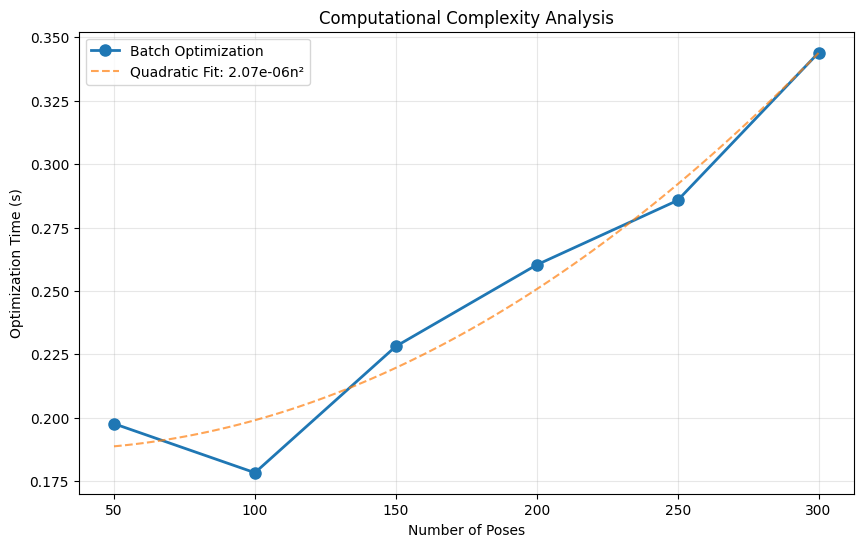

In [82]:
# Plot complexity results
plt.figure(figsize=(10, 6))

plt.plot(pose_counts, complexity_results['batch']['times'], 
         'o-', linewidth=2, markersize=8, label='Batch Optimization')

# Fit polynomial to show scaling
coeffs = np.polyfit(pose_counts, complexity_results['batch']['times'], 2)
fit_x = np.linspace(min(pose_counts), max(pose_counts), 100)
fit_y = np.polyval(coeffs, fit_x)
plt.plot(fit_x, fit_y, '--', alpha=0.7, label=f'Quadratic Fit: {coeffs[0]:.2e}n²')

plt.xlabel('Number of Poses')
plt.ylabel('Optimization Time (s)')
plt.title('Computational Complexity Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

In this final chapter, we covered advanced topics in pose graph optimization:

1. **Loop Closure Detection**: Finding and validating connections between distant poses
2. **Incremental Optimization**: Efficient updates for real-time SLAM
3. **Graph Sparsification**: Maintaining efficiency as the graph grows
4. **Complete SLAM System**: Integration of all components
5. **Multi-Robot SLAM**: Extending to collaborative scenarios
6. **Performance Analysis**: Understanding computational complexity

Key takeaways:
- Loop closures are essential for global consistency
- Incremental methods enable real-time operation
- Sparsification preserves accuracy while reducing computation
- Symforce provides powerful tools for building efficient SLAM systems

## Next Steps

To continue your learning:
1. Implement visual loop closure detection using image features
2. Explore 3D pose graph optimization for full 6-DOF SLAM
3. Study more advanced sparsification techniques (e.g., information-theoretic)
4. Implement distributed optimization for large-scale multi-robot systems
5. Integrate with real sensor data (LiDAR, cameras, IMU)

Congratulations on completing the pose graph optimization tutorial series!